In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def markovDuplaDimensao(linha, coluna, lamb1, lamb2, mu1, mu2):
    m = linha + 1
    n = coluna + 1

    # criando uma matriz para guardar os valores da diagonal princal
    diagonalPrincipal = np.zeros((m, n))

    for x in range(m):
        for y in range(n):
            if x == 0:
                if y == 0:
                    diagonalPrincipal[x][y] = -(lamb1 + lamb2)
                else:
                    diagonalPrincipal[x][y] = -(lamb1 + lamb2 + mu1 * y)
            elif x == linha:
                if y == 0:
                    diagonalPrincipal[x][y] = -(lamb1 + lamb2 + mu2 * x)
                elif y == coluna:
                    diagonalPrincipal[x][y] = -(mu1 * y + mu2 * x)
                else:
                    diagonalPrincipal[x][y] = -(lamb1 + lamb2 + mu1 * y + mu2 * x)
            else:
                if y == 0:
                    diagonalPrincipal[x][y] = -(lamb1 + lamb2 + mu2 * x)
                else:
                    diagonalPrincipal[x][y] = -(lamb1 + lamb2 + mu1 * y + mu2 * x)

    # determinando o tamanho da matriz da cadeia principal
    ordemCadeia = m * n

    # criando a matriz da cadeia principal
    cadeiaPrincipal = np.zeros((ordemCadeia, ordemCadeia))

    # inserindo os valores da diagonal principal na cadeia principal
    x1 = 0
    y1 = 0
    for i in range(ordemCadeia):
        cadeiaPrincipal[i][i] = diagonalPrincipal[x1][y1]
        if y1 < coluna:
            y1 += 1
        else:
            x1 += 1
            y1 = 0

    # inserindo os valores das outras diagonais

    for i in range(ordemCadeia):
        for j in range(ordemCadeia):
            if i == j + 1:
                if (j+1) % n == 0:
                    cadeiaPrincipal[i][j] = 0
                elif (j+1) / n >= linha:
                    cadeiaPrincipal[i][j] = lamb1 + lamb2
                else:
                    cadeiaPrincipal[i][j] = lamb1
            if i == j + n:
                if (j+1) % n == 0:
                    cadeiaPrincipal[i][j] = lamb2 + lamb1
                else:
                    cadeiaPrincipal[i][j] = lamb2
            if j == i + 1:
                cadeiaPrincipal[i][j] = mu1 * (j % n)
            if j == i + n:
                cadeiaPrincipal[i][j] = mu2 * (j // n)
    return cadeiaPrincipal

In [2]:
markovDuplaDimensao(2,1,1,1,1,1)

array([[-2.,  1.,  1.,  0.,  0.,  0.],
       [ 1., -3.,  0.,  1.,  0.,  0.],
       [ 1.,  0., -3.,  1.,  2.,  0.],
       [ 0.,  2.,  1., -4.,  0.,  2.],
       [ 0.,  0.,  1.,  0., -4.,  1.],
       [ 0.,  0.,  0.,  2.,  2., -3.]])

In [3]:
# função para calcular a probabilidade de bloqueio
def calcularPb(cadeiaPrincipal, fixado):
    a = fixado
    vetorFinal = np.full(len(cadeiaPrincipal), 1)
    cadeiaPrincipal[a] = vetorFinal
    col = np.zeros(len(cadeiaPrincipal))
    col[a] = 1

    pb = np.linalg.inv(cadeiaPrincipal).dot(col)
    sum = 0
    for i in range(len(cadeiaPrincipal)):
        sum += pb[i]
    return pb


In [4]:
def jogoOperadoras(op1, op2, trafMax):
    '''
    jogoOperadoras(
        enlaces da operadora 1,
        enlaces da operadora 2,
        trafego máximo
    )
    '''

    # Variável onde serão armazenados os valores que precisamos
    resultados = []
    lucro1 = 0
    lucro2 = 0
    p1 = 0
    p2 = 0
    
    diferenca = 0.005
    c_decimais = 2

    trafMax = trafMax/2

    Pc = 0 # variável para definir o ponto de cruzamento (se houver)

    lucro1_inicio = 0
    lucro2_inicio = 0
    lucro1_fim = 0
    lucro2_fim = 0

    pb1_inicio = 0
    pb2_inicio = 0
    pb1_fim = 0
    pb2_fim = 0


    # calcula as pb's
    for i in np.arange(0, trafMax + 0.1, 0.1):
        total_pb1 = 0
        total_pb2 = 0
        pb1 = []
        pb2 = []
        lamb2 = trafMax - i

        M = calcularPb(markovDuplaDimensao(op1, op2, i, lamb2, 1, 1), -1)
        pb = M[-1]

        # adiciona a pb2 os últimos estados da linha
        for j in range(op2, len(M), op2+1):
            pb2.append(M[j])
            total_pb2 += M[j]


        # adiciona a pb1 os estados da última linha
        for x in range(len(M)-1, len(M)-(op2+2), -1):
            pb1.append(M[x])
            total_pb1 += M[x]

        resultados.append((total_pb1, total_pb2))

        # calculo dos lucros
        if i == 0:
            lucro1_inicio = i * (1-total_pb1) + lamb2 * (total_pb2 - pb) - 0.12 * op1
            lucro2_inicio = lamb2 * (1-total_pb2) + i * (total_pb1 - pb) - 0.12 * op2
            pb1_inicio = total_pb1
            pb2_inicio = total_pb2
         

        if i == trafMax:
            lucro1_fim = i * (1-total_pb1) + lamb2 * (total_pb2 - pb) - 0.12 * op1
            lucro2_fim = lamb2 * (1-total_pb2) + i * (total_pb1 - pb) - 0.12 * op2
            pb1_fim = total_pb1
            pb2_fim = total_pb2
         
        if trafMax < 5: 
            if abs(total_pb1 - total_pb2) < diferenca:
                Pc = i
                lucro1 = i * (1-total_pb1) + lamb2 * (total_pb2 - pb) - 0.12 * op1
                lucro2 = lamb2 * (1-total_pb2) + i * (total_pb1 - pb) - 0.12 * op2
        
        else:
            if round(total_pb1, c_decimais) == round(total_pb2, c_decimais):
                Pc = i
                lucro1 = i * (1-total_pb1) + lamb2 * (total_pb2 - pb) - 0.12 * op1
                lucro2 = lamb2 * (1-total_pb2) + i * (total_pb1 - pb) - 0.12 * op2
                p1 = total_pb1
                p2 = total_pb2
            

        if Pc == 0:
            moduloInicio = abs(pb1_inicio - pb2_inicio)
            moduloFim = abs(pb1_fim - pb2_fim)

            if moduloInicio > moduloFim:
                lucro1 = lucro1_fim
                lucro2 = lucro2_fim
                
                
            else:
                lucro1 = lucro1_inicio
                lucro2 = lucro2_inicio
               

    return {
        'array': resultados,
        'lucro1': lucro1,
        'lucro2': lucro2,
        'p1': p1,
        'p2': p2
        }

In [5]:
def plotar_grafico(resultados):
    """
    Função para plotar o gráfico dos valores de total_pb1 e total_pb2.

    Parâmetros:
    - resultados: lista de tuplas, onde cada tupla contém (total_pb1, total_pb2).
    """
    resultados = resultados['array']
    total_pb1_values = [resultado[0] for resultado in resultados]
    total_pb2_values = [resultado[1] for resultado in resultados]

    # Plotando o gráfico
    plt.plot(total_pb1_values, label="Total PB1", linestyle='-', color='b')
    plt.plot(total_pb2_values, label="Total PB2", linestyle='-', color='r')

    # Adicionando títulos e rótulos
    plt.xlabel('Iterações')
    plt.ylabel('Prob. bloqueio')

    # Adicionando legenda
    plt.legend()

    num_iterations = len(resultados)
    ticks = range(0, num_iterations, 5)  # Posições dos ticks

    # Dividindo os ticks por 10
    plt.xticks(ticks, [tick / 10 for tick in ticks])

    # Exibindo o gráfico
    plt.savefig('jogoOperadoras.png')
    plt.show()

    print('\n')


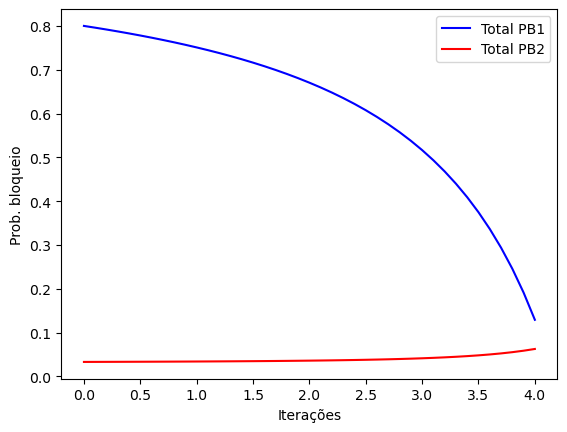

In [14]:
plotar_grafico(jogoOperadoras(1,7,8))


In [7]:
def distribuicaoDeJogos(slots):
    t = slots + 1
    for i in range(t):
        for j in range(t):
            print(f'{jogoOperadoras(i,j,i+j)["lucro1"]:.2f} {jogoOperadoras(i,j,i+j)["lucro2"]:.2f}')
            
        print('\n')

In [8]:
distribuicaoDeJogos(15)

0.00 0.00
0.00 0.21
0.00 0.56
0.00 0.94
0.00 1.33
0.00 1.73
0.00 2.12
0.00 2.52
0.00 2.92
0.00 3.31
0.00 3.71
0.00 4.10
0.00 4.49
0.00 4.88
0.00 5.27
0.00 5.66


0.21 0.00
0.28 0.28
0.88 0.06
1.42 -0.09
1.88 -0.15
2.36 -0.24
2.85 -0.33
3.36 -0.44
3.88 -0.57
4.40 -0.70
4.93 -0.83
5.46 -0.97
5.99 -1.11
6.53 -1.26
7.06 -1.40
7.59 -1.54


0.56 0.00
0.06 0.88
0.66 0.66
1.29 0.44
1.91 0.22
2.94 -0.42
3.45 -0.53
3.96 -0.65
4.48 -0.77
5.00 -0.90
5.52 -1.02
6.04 -1.16
6.56 -1.29
7.08 -1.42
7.59 -1.55
8.11 -1.68


0.94 -0.00
-0.09 1.42
0.44 1.29
1.06 1.06
2.90 -0.38
3.40 -0.49
2.96 0.35
3.55 0.16
4.95 -0.84
4.78 -0.29
5.41 -0.53
6.49 -1.22
6.55 -0.89
7.06 -1.02
7.82 -1.39
8.21 -1.39


1.33 0.00
-0.15 1.88
0.22 1.91
-0.38 2.90
1.46 1.46
2.08 1.23
2.74 0.97
3.43 0.68
4.01 0.48
4.61 0.27
5.34 -0.07
6.91 -1.26
6.46 -0.42
6.96 -0.53
7.70 -0.89
8.09 -0.89


1.73 0.00
-0.24 2.36
-0.42 2.94
-0.49 3.40
1.23 2.08
1.85 1.85
2.50 1.60
3.18 1.32
3.75 1.13
6.30 -1.03
5.05 0.61
5.65 0.39
6.14 0.29
6.88 -0.06
7